# Prediction of Aqueous Solubility (LogS) of Organic Molecules

The goal of this notebook is to develop a machine learning model that predicts
**aqueous solubility (LogS)** from molecular descriptors.

Objectives:

1. **Compare linear and nonlinear regression models**  
   to understand whether solubility can be predicted as a linear function of molecular descriptors,
   or whether nonlinear interactions dominate.

2. **Identify a compact set of meaningful descriptors**  
   (initial dataset contains ≈ 44 computed molecular descriptors).

3. **Select and export the best performing model**  
   that will later be deployed behind a web API (Flask).

---

### Why multiple models?

Solubility is influenced by diverse molecular properties: size, polarity,
surface area, HOMO/LUMO energies, etc.  
Some relationships may be linear, others nonlinear.

| Model group             | Examples                 | Question answered |
|------------------------|---------------------------|-------------------|
| **Linear models**      | PLS, Elastic Net     | *Is solubility predictable as a linear combination of descriptors?* |
| **Nonlinear models**   | ANN, SVM, Gaussian Process | *Do nonlinear patterns help explain solubility?* |
| **Tree ensembles**     | Random Forest, Extra Trees, XGBoost | *Do ensemble models outperform individual learners?* |

- **Elastic Net** helps interpret descriptor importance (sparse linear model).
- **PLS** handles multicollinearity (descriptors are highly correlated).
- **Random Forest / XGBoost** generally perform best on structured descriptor data.

> Although some literature suggests ANNs for solubility prediction,
> our dataset is relatively small (~100–200 molecules).  
> Deep learning models require more data, while **tree-based methods and elastic-net models perform better on small tabular datasets**.

---

### Model overview

| Model | Type | Why included |
|--------|------|--------------|
| **PLS** | Linear (handles correlated descriptors) | Many descriptors are correlated → PLS reduces dimensionality. |
| **Elastic Net** | Linear + feature selection | Identifies most informative descriptors → interpretable. |
| **Random Forest / XGBoost** | Tree ensembles | Usually best performance on small numeric descriptor datasets. |

---

### Deployment

After selecting the best model, it will be exported (pickle) and integrated into a **Flask API**, allowing users to upload descriptors and receive predicted solubility via `src/train.py` and `src/predict.py` scripts.



Import libraries

In [ ]:
# Core
import os
from pathlib import Path
import pickle

# Data and math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Regression models
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Set working directory (optional)
os.chdir("/home/katwre/projects/Solubility/")

/home/katwre/projects/machine-learning-zoomcamp/homeworks/06-trees/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download input datasets:
- Dataset containing solubility and other features of moelcules
- Dataset that contains description of features of molecules

In [2]:
# Download input dataset
#!mkdir -p data
#!wget -P data https://zenodo.org/records/3686213/files/BNNLab/Solubility_data-1.0.zip
#!unzip data/Solubility_data-1.0.zip -d data

In [3]:
df = pd.read_csv('./data/Solubility_data-1.0/Descriptors/water_set_narrow_descriptors.csv')
df.head()

,StdInChIKey,SMILES,Train_test,LogS,MW,MP,Volume,E0_gas,E0_solv,DeltaE0_sol,...,Asp1,Asp2,Asp3,No_regions,Tot_charge,Neg_charge,Pos_charge,Big_area,Big_charge,Big_std
0,ABICJYZKIYUWEE-UHFFFAOYSA-N,C1(C(=O)NC(=O)NC1=O)[N+](=O)[O-],Train,-2.28000,173.0848,183.0,87.688,-694.571841,-694.592661,-0.020820,...,0.614627,0.790141,1.000000,3,144.210031,-172.576191,316.786221,5042,0.062829,0.023131
1,ADIMAYPTOBDMTL-UHFFFAOYSA-N,c1ccc(cc1)C1=NC(C(=O)Nc2ccc(cc12)Cl)O,Train,-3.95000,286.7171,205.0,193.062,-1298.402301,-1298.419767,-0.017466,...,0.587793,0.592048,0.894574,4,80.174537,-204.379352,284.553889,7085,0.038042,0.017338
2,AFOGBLYPWJJVAL-UHFFFAOYSA-N,CCCCNC(=O)NS(=O)(=O)c1ccccc1,Test,-3.05000,256.3190,131.0,239.975,-1162.159257,-1162.179872,-0.020615,...,0.485869,0.561473,0.838179,2,-1.512493,-299.829370,298.316877,7404,0.040291,0.021328
3,AFPHTEQTJZKQAQ-UHFFFAOYSA-N,c1cc(cc(c1)[N+](=O)[O-])C(=O)O,Test,-1.71997,167.1208,141.0,100.033,-625.337612,-625.354809,-0.017197,...,0.423495,0.529651,0.985866,3,132.371223,-166.306523,298.677746,6975,0.042821,0.018583
4,AGMMTXLNIQSRCG-UHFFFAOYSA-N,CCC1Nc2cc(c(cc2C(=O)N1)S(=O)(=O)N)Cl,Test,-3.29000,289.7361,275.5,204.960,-1636.586825,-1636.613963,-0.027138,...,0.476232,0.630041,0.762783,3,94.829107,-353.763532,448.592640,7666,0.049700,0.020397


In [4]:
print("Dimensions of input dataset (rows, columns): ", df.shape)

Dimensions of input dataset (rows, columns):  (560, 45)


In [5]:
desc_file = Path("./data/Solubility_data-1.0/Descriptors/READ_ME_DESCRIPTORS.txt")

rows = []
for line in desc_file.read_text().splitlines():
    line = line.strip()
    # skip empty/title/underline lines
    if not line or set(line) == {"="} or line.lower().startswith("column key"):
        continue
    if "=" in line:
        k, v = line.split("=", 1)   # split only on the first '='
        rows.append([k.strip(), v.strip()])

df_desc = pd.DataFrame(rows, columns=["Column", "Description"])
df_desc

,Column,Description
0,StdInChIKey,StdInChIKey for molecule; unique identifier
1,SMILES,SMILES code for molecule
2,Train_test,Whether molecule was in training or test set
3,LogS,"Solubility (log base 10 C, where C = concentra..."
4,MW,Molecular Weight
5,MP,Experimental melting point in Deg C
6,Volume,Molar volume in cm^3 mol^-1
7,E0_gas,Gas Phase Zero Point Energy in Ha
8,G_gas,Gas Phase Gibbs Energy in Ha
9,E0_solv,Solution Phase Zero Point Energy in Ha


## Exploratory data analysis (EDA)

In [6]:
X = df.drop(columns=["LogS", "SMILES", "StdInChIKey", "Train_test"])  # remove target + metadata
y = df["LogS"]

/tmp/ipykernel_385740/387218620.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


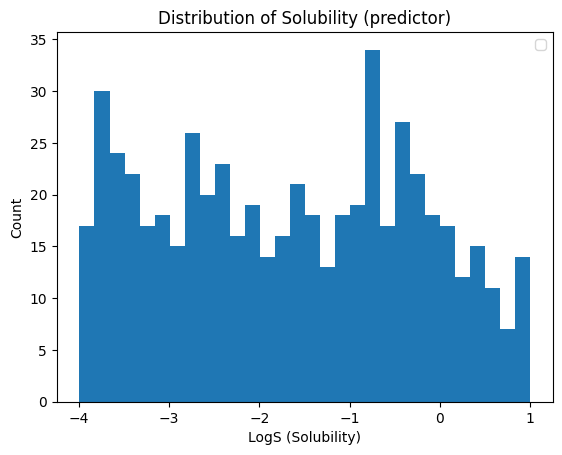

In [7]:
plt.hist(y, bins=30)
plt.xlabel("LogS (Solubility)")
plt.ylabel("Count")
plt.title("Distribution of Solubility (predictor)")
plt.legend()
plt.show()

In [8]:
print("Total number of missing values in X = ", X.isnull().sum().sum())

Total number of missing values in X =  0


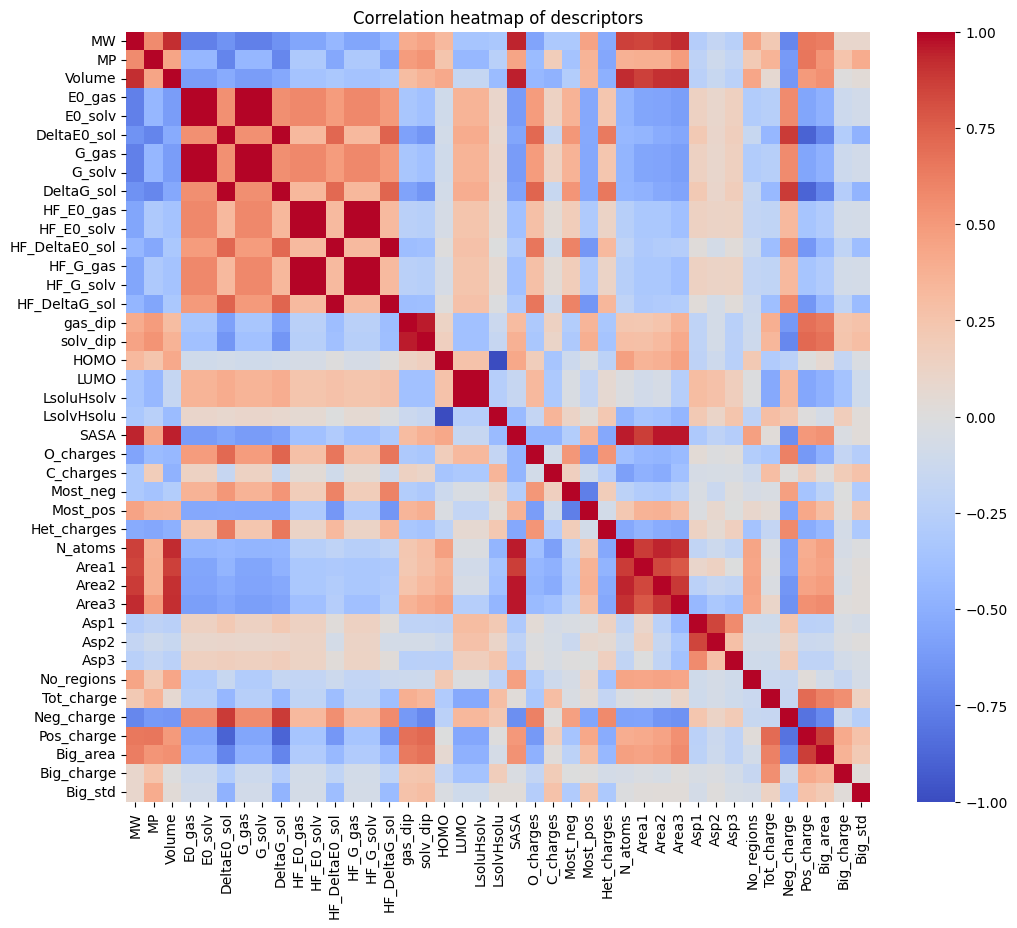

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation heatmap of descriptors")
plt.show()

Heatmap shows blocks of strongly correlated descriptors, exactly like what the original paper by [Boobier et al Nature Communications 2020](https://www.nature.com/articles/s41467-020-19594-z) described. A linear regresion might not handle it well, but then Elastic Net should handle correlation automatically, tree models (random forest and XGBoostg) don't care about collinearity and Partial Least Squares is linear but handles multicollinearity and preserves relationship with the target (and it's commonly used in chemometrics).

In [10]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
MW,560.0,197.967381,85.606665,26.037800,122.177950,197.147000,257.522575,495.401600
MP,560.0,102.170347,106.009444,-169.000000,33.300000,112.625000,177.000000,517.000000
Volume,560.0,144.690613,59.437047,28.766000,96.761750,137.426000,186.067500,361.097000
E0_gas,560.0,-841.652171,536.727516,-5541.980089,-1056.827579,-740.300846,-460.139330,-77.333103
E0_solv,560.0,-841.666811,536.731382,-5541.990677,-1056.841037,-740.323067,-460.151664,-77.336753
DeltaE0_sol,560.0,-0.014640,0.007077,-0.058414,-0.019014,-0.013906,-0.009475,-0.000216
G_gas,560.0,-841.489943,536.699956,-5541.932687,-1056.559911,-740.152630,-460.031827,-77.325996
G_solv,560.0,-841.504890,536.703899,-5541.943361,-1056.574696,-740.175757,-460.043390,-77.328920
DeltaG_sol,560.0,-0.014947,0.007123,-0.060750,-0.019288,-0.014271,-0.009864,-0.000684
HF_E0_gas,560.0,-876.194190,867.299657,-14092.515880,-1051.687210,-728.944634,-453.767187,-75.852015


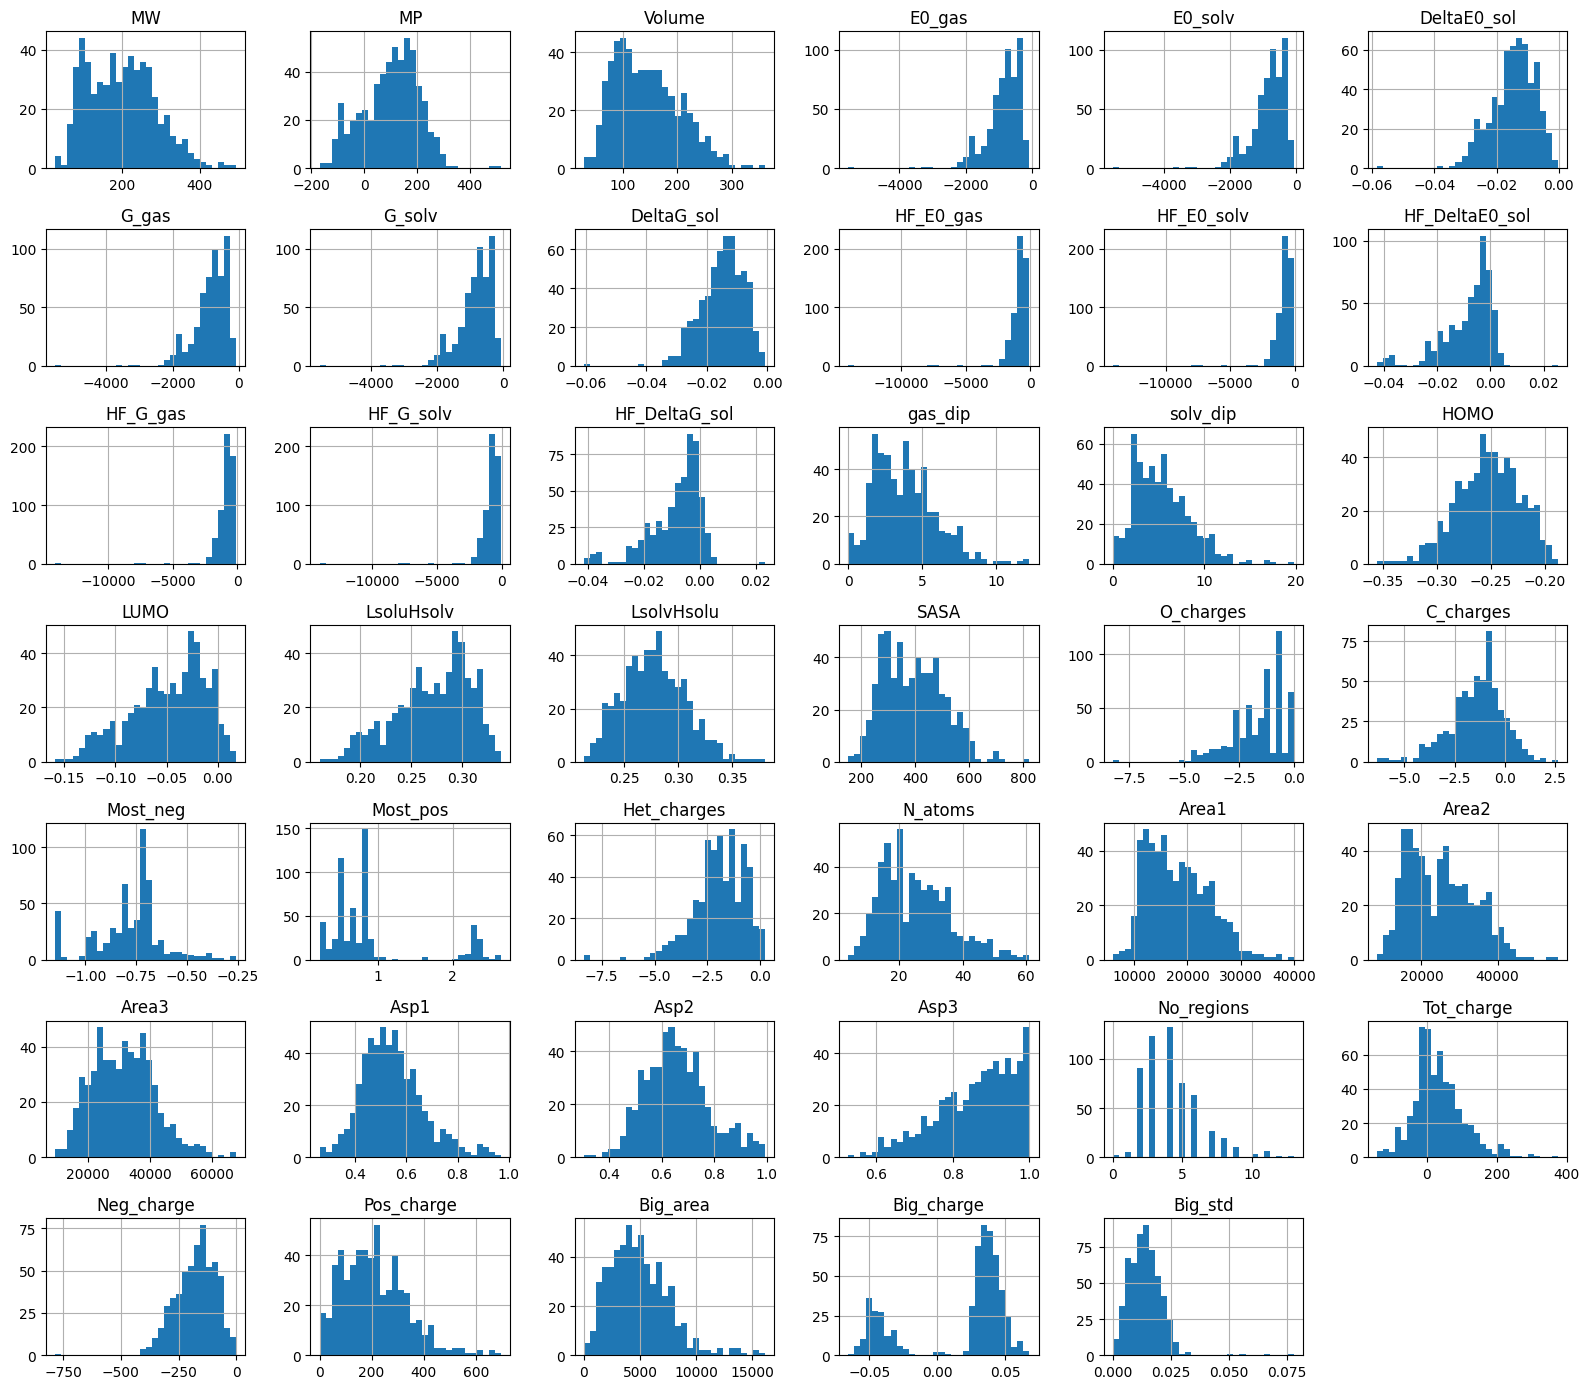

In [11]:
X.hist(figsize=(16, 14), bins=30)
plt.tight_layout()
plt.show()

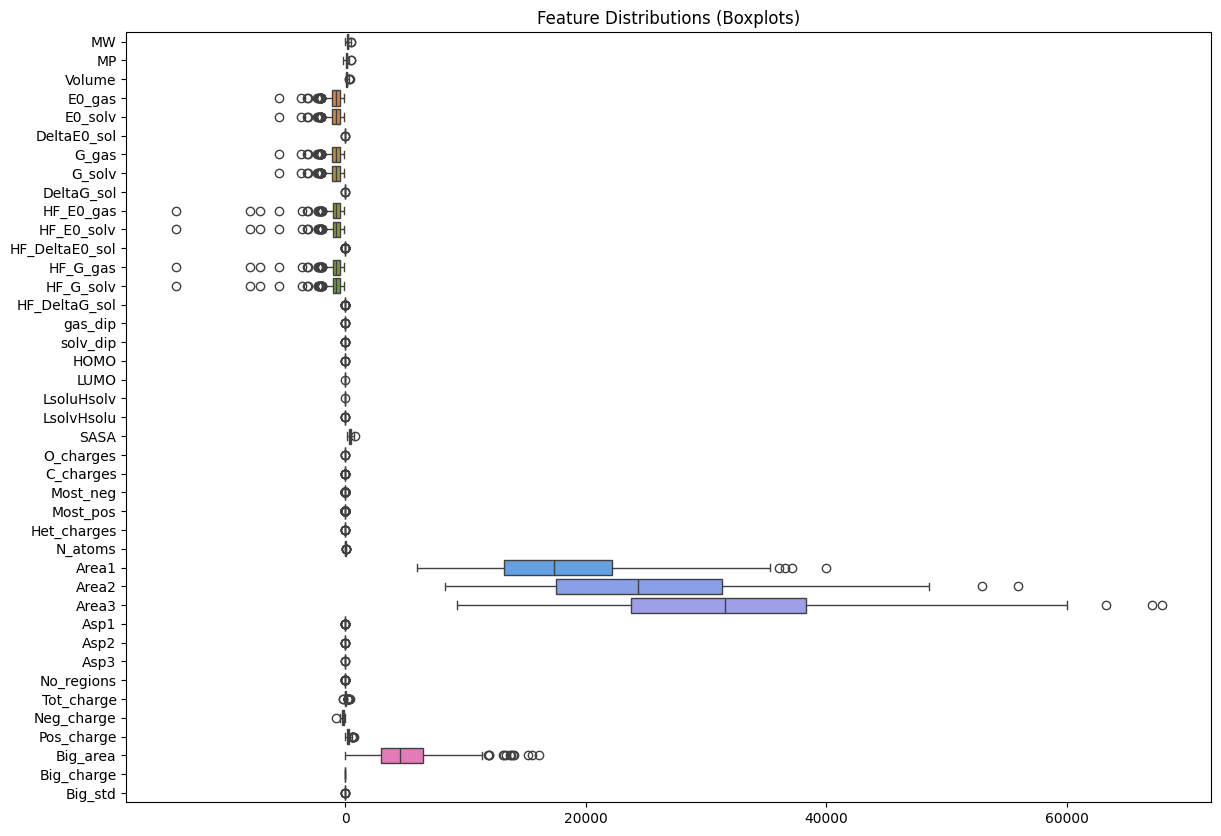

In [12]:
plt.figure(figsize=(14, 10))
sns.boxplot(data=X, orient='h')
plt.title("Feature Distributions (Boxplots)")
plt.show()

The features span different numerical scales, so scaling will be necessary before applying machine learning models.

## Modelling

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Partial least squares (PLS)

PLS produces latent components that combine correlated descriptors into a smaller number of independent variables. That’s why chemists and cheminformatics people love it.

In [14]:
# Scale data and fit PLS with cross-validation to find optimal components
results = []
for n_comp in range(1, min(15, X.shape[1])+1):
    pls = Pipeline([
        ("scaler", StandardScaler()),
        ("pls", PLSRegression(n_components=n_comp))
    ])

    scores = cross_val_score(pls, X, y, cv=5, scoring='neg_root_mean_squared_error')
    rmse = -scores.mean()
    print(f"Components: {n_comp}, Train RMSE: {rmse:.3f}")
    results.append({"components": n_comp, "rmse": rmse})
results = pd.DataFrame(results)
results = results.sort_values(by="rmse", ascending=True)
best_n = results.iloc[0]["components"]

# Train final PLS model with best number of components
best_components = int(best_n)

pls = Pipeline([
    ("scaler", StandardScaler()),
    ("pls", PLSRegression(n_components=best_components))
])
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)

# Evaluate performance
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
pls_rmse = rmse
pls_r2 = r2

print(f"PLS → #components: {best_components}, Test RMSE: {rmse:.3f}, R²: {r2:.3f}")

# Save model to a pickle file
with open("models/PLS_model.pkl", "wb") as f:
    pickle.dump(pls, f)

Components: 1, Train RMSE: 1.099
Components: 2, Train RMSE: 0.977
Components: 3, Train RMSE: 0.943
Components: 4, Train RMSE: 0.935
Components: 5, Train RMSE: 0.920
Components: 6, Train RMSE: 0.913
Components: 7, Train RMSE: 0.908
Components: 8, Train RMSE: 0.904
Components: 9, Train RMSE: 0.899
Components: 10, Train RMSE: 0.897
Components: 11, Train RMSE: 0.902
Components: 12, Train RMSE: 0.909
Components: 13, Train RMSE: 0.908
Components: 14, Train RMSE: 0.908
Components: 15, Train RMSE: 0.910
PLS → #components: 10, Test RMSE: 0.718, R²: 0.580


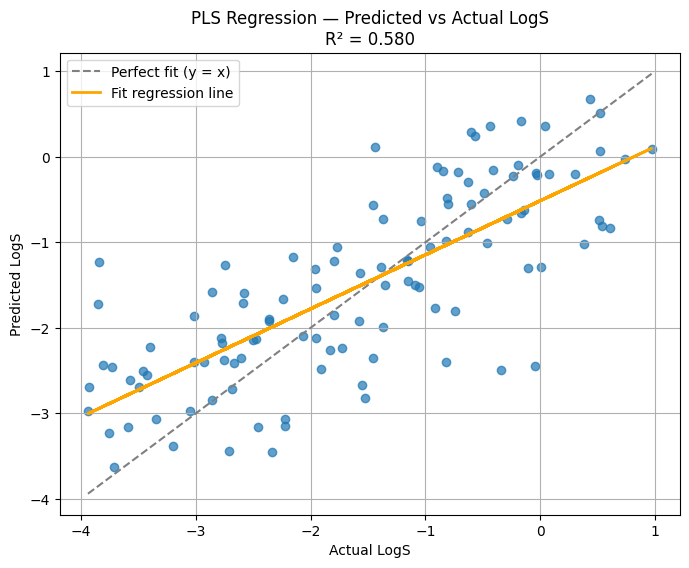

In [15]:
# Plot predicted vs. actual LogS

# If your predictions are shaped like (n,1), flatten them:
y_pred_flat = y_pred.ravel()

# Fit a line (least squares)
coef = np.polyfit(y_test, y_pred_flat, 1)
poly1d_fn = np.poly1d(coef)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_flat, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle="--", color="grey", label="Perfect fit (y = x)")
plt.plot(y_test, poly1d_fn(y_test), color="orange", linewidth=2, label="Fit regression line")
plt.xlabel("Actual LogS")
plt.ylabel("Predicted LogS")
plt.title(f"PLS Regression — Predicted vs Actual LogS\nR² = {r2:.3f}")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Extract and rank variables by importance (VIP Scores)
def calculate_vip(pls, X):
    """Calculate VIP scores for PLSRegression"""
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_

    p, h = w.shape
    vip = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j])) ** 2 for j in range(h)])
        vip[i] = np.sqrt(p * np.sum(weight * s.flatten()) / total_s)

    return vip

# Extract fitted model (from Pipeline)
pls_model = pls.named_steps["pls"]

vip_scores = calculate_vip(pls_model, X_train.values)
vip_df = pd.DataFrame({
    "feature": X.columns,
    "VIP": vip_scores
}).sort_values("VIP", ascending=False)

vip_df.head(15)

,feature,VIP
30,Area3,1.370609
0,MW,1.351905
21,SASA,1.289872
2,Volume,1.268235
19,LsoluHsolv,1.249761
18,LUMO,1.249761
26,Het_charges,1.180839
29,Area2,1.155419
5,DeltaE0_sol,1.140871
27,N_atoms,1.121436


### Elastic net

AFter tuning parameters I can see that the model mostly behaves like Ridge, not Lasso. It means that it prefers shrinking coefficients over forcing many of them to zero. It keeps most variables in the model, suggesting many descriptors contain useful (but correlated) information.

In [17]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("enet", ElasticNet(max_iter=5000, random_state=42))
])
# Hyperparameters to tune
param_grid = {
    "enet__alpha": np.logspace(-3, 2, 20),  # 0.001 ... 100
    "enet__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]  # 0=ridge, 1=lasso
}

# Search for the best hyperparameters using cross-validation
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5, # k-folds
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV best Train RMSE:", -grid.best_score_)

# --- evaluate on held-out test set ---
best_model_enet = grid.best_estimator_
y_pred = best_model_enet.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
pct_within_0p7 = np.mean(np.abs(y_pred - y_test) <= 0.7) * 100
enet_rmse = rmse
enet_r2 = r2

print(f"Elastic Net → Test RMSE: {rmse:.3f}, R²: {r2:.3f}, %|err|≤0.7: {pct_within_0p7:.1f}%")

# Save model to a pickle file
with open("models/elastic_net_model.pkl", "wb") as f:
    pickle.dump(best_model_enet, f)

/home/katwre/projects/machine-learning-zoomcamp/homeworks/06-trees/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.230e-01, tolerance: 7.256e-02
  model = cd_fast.enet_coordinate_descent(
/home/katwre/projects/machine-learning-zoomcamp/homeworks/06-trees/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e-01, tolerance: 6.888e-02
  model = cd_fast.enet_coordinate_descent(
/home/katwre/projects/machine-learning-zoomcamp/homeworks/06-trees/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objecti

Best params: {'enet__alpha': np.float64(0.06951927961775606), 'enet__l1_ratio': 0.1}
CV best Train RMSE: 0.9242130581711689
Elastic Net → Test RMSE: 0.719, R²: 0.580, %|err|≤0.7: 63.4%


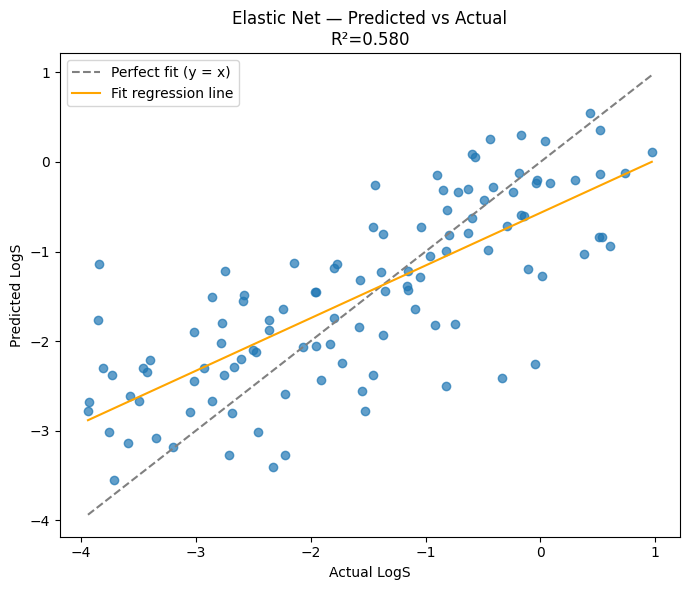

In [18]:
# Parity plot with regression line + R^2
coef = np.polyfit(y_test, y_pred, 1)
line = np.poly1d(coef)

plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.7)
# parity y=x
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle="--", color="grey", label="Perfect fit (y = x)")
# fitted line
plt.plot(sorted(y_test), line(sorted(y_test)), color="orange", label="Fit regression line")
plt.xlabel("Actual LogS")
plt.ylabel("Predicted LogS")
plt.title(f"Elastic Net — Predicted vs Actual\nR²={r2:.3f}")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Coefficients (feature importance for interpretability)
enet = best_model_enet.named_steps["enet"]
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": enet.coef_,
    "abs_coef": np.abs(enet.coef_)
}).sort_values("abs_coef", ascending=False)

coef_df.head(15)

,feature,coef,abs_coef
0,MW,-0.272009,0.272009
25,Most_pos,-0.268230,0.268230
26,Het_charges,-0.264986,0.264986
5,DeltaE0_sol,-0.244182,0.244182
1,MP,-0.243716,0.243716
30,Area3,-0.236711,0.236711
24,Most_neg,-0.198007,0.198007
21,SASA,-0.184450,0.184450
22,O_charges,-0.162271,0.162271
2,Volume,-0.146314,0.146314


### Random forest

Random Forest is an ensemble model that builds many independent decision trees on random subsets of data and features. The final prediction is the average of all tree outputs, which reduces overfitting and improves generalization.

In [20]:
param_grid = {
    "n_estimators": [200, 400, 600],       # number of trees
    "max_depth": [None, 10, 20, 40],       # tree depth
    "min_samples_split": [2, 5, 10],       # minimum samples to split an internal node
    "min_samples_leaf": [1, 2, 4],         # minimum samples at a leaf node
}

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

#grid = GridSearchCV(
#    rf,
#    param_grid,
#    scoring="neg_root_mean_squared_error",
#    cv=5,
#    n_jobs=-1
#)

#grid.fit(X_train, y_train)

#print("Best RF params:", grid.best_params_)
#print("CV best Train RMSE:", -grid.best_score_)
#Best RF params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
#CV best Train RMSE: 0.8657150661611095

# final model
#best_rf = grid.best_estimator_

# Save model to a pickle file
#with open("models/random_forest_model.pkl", "wb") as f:
#    pickle.dump(best_rf, f)

with open("models/random_forest_model.pkl", "rb") as f:
    best_rf = pickle.load(f)

In [21]:
# --- prediction ---
y_pred = best_rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
pct_within_0p7 = np.mean(np.abs(y_pred - y_test) <= 0.7) * 100
rmse_rf = rmse
r2_rf = r2 

print(f"Random Forest → Test RMSE: {rmse:.3f}, R²: {r2:.3f}, %|err| ≤ 0.7: {pct_within_0p7:.1f}%")

Random Forest → Test RMSE: 0.504, R²: 0.706, %|err| ≤ 0.7: 71.4%


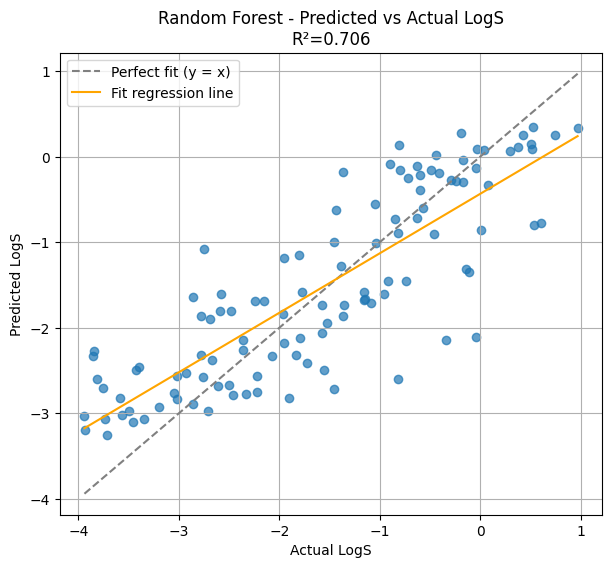

In [22]:
# Predict using Random Forest
y_pred_rf = best_rf.predict(X_test)

# Fit linear regression line (for visualization only)
coef = np.polyfit(y_test, y_pred_rf, 1)
line = np.poly1d(coef)

plt.figure(figsize=(7,6))

# Scatter of predicted vs actual
plt.scatter(y_test, y_pred_rf, alpha=0.7)

# Parity line: perfect predictions (y = x)
lims = [
    min(y_test.min(), y_pred_rf.min()),
    max(y_test.max(), y_pred_rf.max())
]
plt.plot(lims, lims, "--", color="gray", label="Perfect fit (y = x)")

# Regression line through the predicted points
plt.plot(sorted(y_test), line(sorted(y_test)), color="orange", label="Fit regression line")

r2 = r2_score(y_test, y_pred_rf)

plt.xlabel("Actual LogS")
plt.ylabel("Predicted LogS")
plt.title(f"Random Forest - Predicted vs Actual LogS\nR²={r2:.3f}")
plt.legend()
plt.grid()
plt.show()


In [23]:
# Feature importance as DataFrame
rf_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": best_rf.feature_importances_
}).sort_values("importance", ascending=False)

# Show top 15
rf_importance.head(15)

,feature,importance
30,Area3,0.306733
0,MW,0.152769
26,Het_charges,0.072772
32,Asp2,0.026268
23,C_charges,0.023534
24,Most_neg,0.023474
18,LUMO,0.020137
22,O_charges,0.019757
11,HF_DeltaE0_sol,0.018678
25,Most_pos,0.018606


### XGBoost regression

XGBoost is a gradient boosting algorithm that builds decision trees sequentially. Each new tree learns to correct the errors made by the previous trees. We use XGBoost here to model nonlinear relationships between molecular descriptors and solubility (LogS).

In [24]:
# XGBoost model
xgb = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42
)

# Hyperparameter search space
param_dist = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0.0, 0.1, 1.0],  # L1
    "reg_lambda": [0.5, 1.0, 2.0], # L2
}

# Use RandomizedSearch to speed up
#rs = RandomizedSearchCV(
#    xgb,
#    param_distributions=param_dist,
#    n_iter=30,                  
#    cv=3,
#    scoring="neg_root_mean_squared_error",
#    verbose=1,
#    n_jobs=-1,
#    random_state=42
#)

#rs.fit(X_train, y_train)
#print("Best XGB params:", rs.best_params_)
#print("CV best Train RMSE:", -rs.best_score_)

# Final trained model
#best_xgb = rs.best_estimator_

# Save model to a pickle file
#with open("models/xgboost_model.pkl", "wb") as f:
#    pickle.dump(best_xgb, f)

with open("models/xgboost_model.pkl", "rb") as f:
    best_xgb = pickle.load(f)

In [25]:
y_pred = best_xgb.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
pct_within_0p7 = np.mean(np.abs(y_pred - y_test) <= 0.7) * 100
rmse_best_xgb = rmse
r2_xgb = r2

print(f"XGBoost → Test RMSE: {rmse:.3f}, R²: {r2:.3f}, %|err| ≤ 0.7: {pct_within_0p7:.1f}%")

XGBoost → Test RMSE: 0.477, R²: 0.721, %|err| ≤ 0.7: 74.1%


In [26]:
# This metrics tells how much a feature is used in splits, I don't use SHAP values
xgb_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": best_xgb.feature_importances_
}).sort_values("importance", ascending=False)
xgb_importance.head(15)

,feature,importance
10,HF_E0_solv,0.212674
30,Area3,0.099338
0,MW,0.073353
9,HF_E0_gas,0.059536
3,E0_gas,0.035155
26,Het_charges,0.031675
13,HF_G_solv,0.031166
18,LUMO,0.030100
19,LsoluHsolv,0.022155
32,Asp2,0.021184


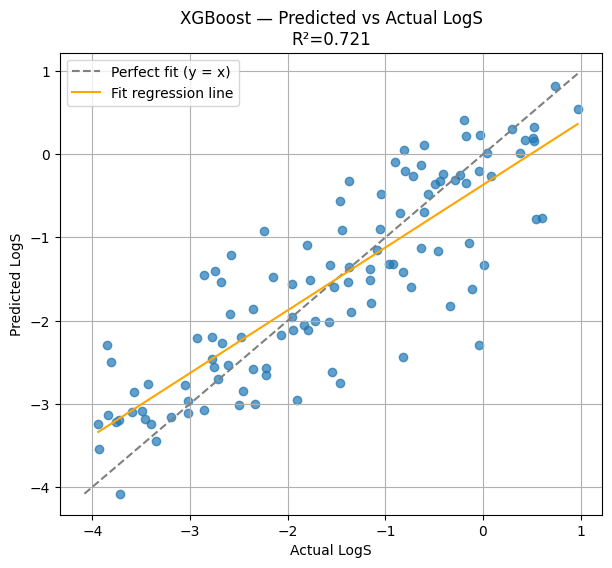

In [27]:
# Predict using the best XGBoost model
y_pred_xgb = best_xgb.predict(X_test)

# Fit regression line (orange line on the plot)
coef = np.polyfit(y_test, y_pred_xgb, 1)
line = np.poly1d(coef)

# R² score
r2 = r2_score(y_test, y_pred_xgb)

plt.figure(figsize=(7,6))

# Scatter: predicted vs actual LogS
plt.scatter(y_test, y_pred_xgb, alpha=0.7)

# Perfect prediction line (y=x) -- dashed
lims = [
    min(y_test.min(), y_pred_xgb.min()),
    max(y_test.max(), y_pred_xgb.max())
]
plt.plot(lims, lims, "--", color="gray", label="Perfect fit (y = x)")

# Regression fit (solid orange)
plt.plot(sorted(y_test), line(sorted(y_test)), color="orange", label="Fit regression line")

plt.xlabel("Actual LogS")
plt.ylabel("Predicted LogS")
plt.title(f"XGBoost — Predicted vs Actual LogS\nR²={r2:.3f}")
plt.legend()
plt.grid()
plt.show()

# Final model

XGBoost achieved the best performance, obtaining the lowest RMSE and the highest R2. This indicates that gradient-boosted trees capture nonlinear relationships between molecular descriptors and solubility more effectively than linear models (Elastic Net, PLS) or bagging-based methods (Random Forest).

In [28]:
results = pd.DataFrame({
    "Model": ["XGBoost", "Random Forest", "Elastic Net", "Partial Least Squares"],
    "RMSE": [rmse_best_xgb, rmse_rf, enet_rmse, pls_rmse],
    "R²": [r2_xgb, r2_rf, enet_r2, pls_r2]
})
print(results.to_string(index=False, formatters={"RMSE": "{:.3f}".format, "R²": "{:.3f}".format}))

                Model  RMSE    R²
              XGBoost 0.477 0.721
        Random Forest 0.504 0.706
          Elastic Net 0.719 0.580
Partial Least Squares 0.718 0.580


When it comes to features:

In [ ]:
# Ensure each DF has standardized column names
xgb_importance.rename(columns={"importance": "XGB"}, inplace=True)
rf_importance.rename(columns={"importance": "RF"}, inplace=True)
coef_df.rename(columns={"coef": "ElasticNet"}, inplace=True)
vip_df.rename(columns={"VIP": "PLS_VIP"}, inplace=True)

# Merge into one table
feature_importance_all = (
    xgb_importance
    .merge(rf_importance, on="feature", how="left")
    .merge(coef_df, on="feature", how="left")
    .merge(vip_df, on="feature", how="left")
)

# Sort by XGBoost importance (or choose any column)
feature_importance_all = feature_importance_all.sort_values(by="XGB", ascending=False)
feature_importance_all = feature_importance_all.rename(columns={
    "XGB": "XGBoost",
    "RF": "RandomForest",
    "ElasticNet": "Elastic Net",
    "abs_coef": "Elastic Net (abs)",
    "PLS_VIP": "PLS"
})

display(feature_importance_all.head(15))

,feature,XGBoost,RandomForest,Elastic Net,Elastic Net (abs),PLS
0,HF_E0_solv,0.212674,0.011814,-0.000000,0.000000,0.858611
1,Area3,0.099338,0.306733,-0.236711,0.236711,1.370609
2,MW,0.073353,0.152769,-0.272009,0.272009,1.351905
3,HF_E0_gas,0.059536,0.010533,-0.000000,0.000000,0.858611
4,E0_gas,0.035155,0.007449,0.038230,0.038230,1.101823
5,Het_charges,0.031675,0.072772,-0.264986,0.264986,1.180839
6,HF_G_solv,0.031166,0.007347,-0.000000,0.000000,0.858541
7,LUMO,0.030100,0.020137,0.125314,0.125314,1.249761
8,LsoluHsolv,0.022155,0.018417,0.125275,0.125275,1.249761
9,Asp2,0.021184,0.026268,0.099542,0.099542,0.952430


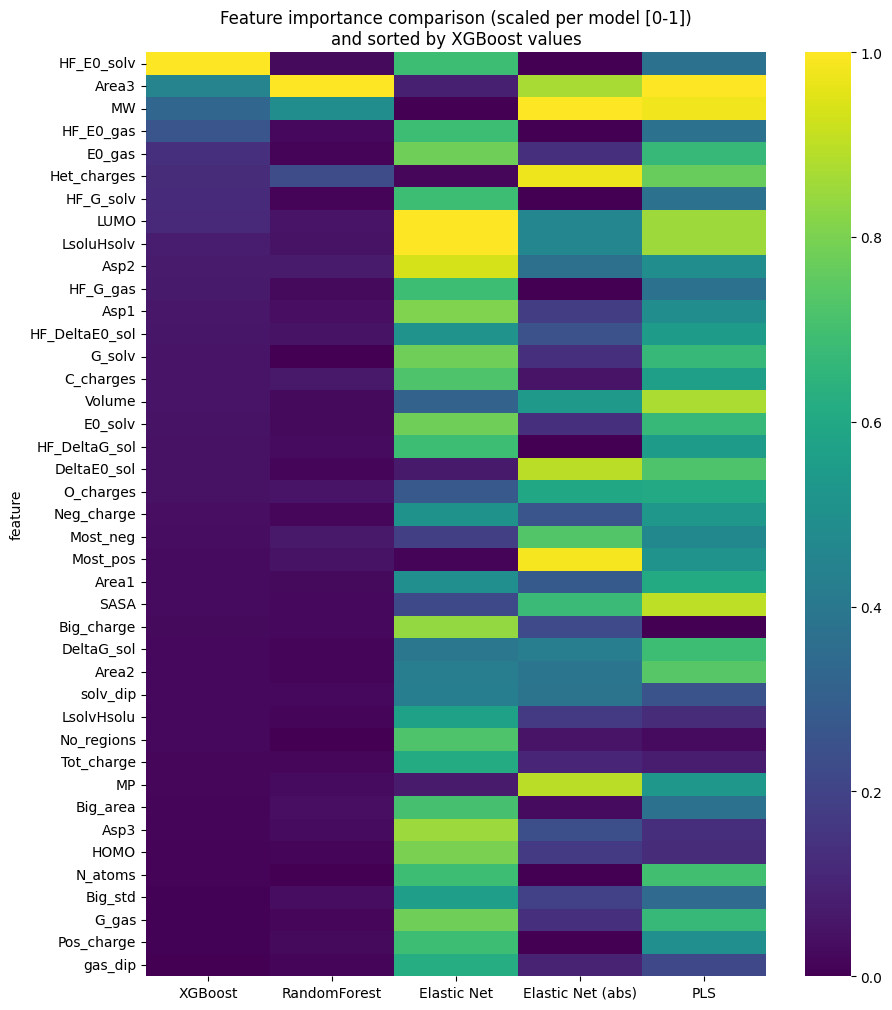

In [47]:
# normalize each column between 0 and 1
viz = feature_importance_all.copy()
viz = viz.set_index("feature")

viz_scaled = (viz - viz.min()) / (viz.max() - viz.min())

plt.figure(figsize=(10, 12))
sns.heatmap(viz_scaled, cmap="viridis")
plt.title("Feature importance comparison (scaled per model [0-1])\nand sorted by XGBoost values")
plt.show()

From the heatmap, the consistently important descriptors across models include:

| Descriptor (example name in your data) | Why relevant                             |
| -------------------------------------- | ---------------------------------------- |
| `Area3`              | Surface area → interaction with water    |
| `MW`              | Molecular Weight; Core determinant of solubility           |
| `HF_E0_solv` / `HF_E0_gas`             | Solvation and gas-phase energy           |
| `Het_charges`, `C_charges`             | Charge distribution                      |
| `LUMO` / `HOMO`                        | Electronegativity & molecular reactivity |
| `Volume`                               | Packing & solubility                     |
| `SASA`                                 | Solvent-accessible surface area          |


I'm going to try to retrain the model using only the top 10 features by XGBoost importance, then compare performance with the full XGBoost model.


XGBoost (Top 10 features) → RMSE: 0.484, R²: 0.717


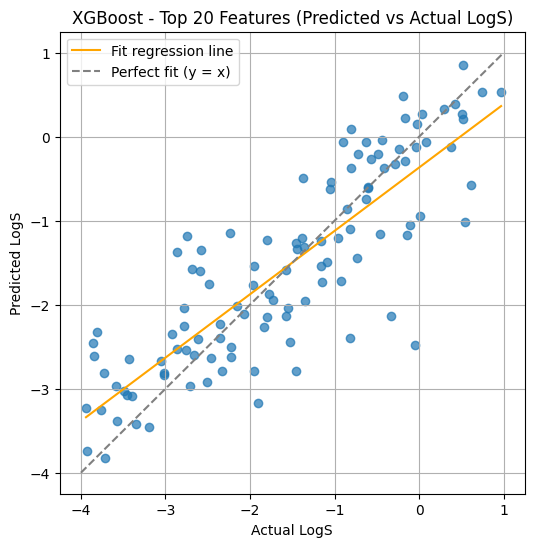

In [55]:
top_features = xgb_importance.head(20)["feature"].tolist()

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

best_xgb.fit(X_train_top, y_train)

# predict on the reduced feature set
y_pred_top = best_xgb.predict(X_test_top)

rmse_top = mean_squared_error(y_test, y_pred_top)
r2_top = r2_score(y_test, y_pred_top)

print(f"XGBoost (Top 10 features) → RMSE: {rmse_top:.3f}, R²: {r2_top:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_top, alpha=0.7)
plt.plot(sorted(y_test), line(sorted(y_test)), color="orange", label="Fit regression line")
plt.plot([-4, 1], [-4, 1], linestyle='--', color='grey', label="Perfect fit (y = x)")
plt.xlabel("Actual LogS")
plt.ylabel("Predicted LogS")
plt.title("XGBoost - Top 20 Features (Predicted vs Actual LogS)")
plt.legend()
plt.grid()
plt.show()


Using XGBoost feature importance for descriptor selection, reducing the input set from 44 to 20 descriptors preserved predictive power (RMSE 0.477 → 0.484, R² 0.721 → 0.717), while reducing the input size by ~50%. This confirms that solubility is driven primarily by a subset of key structural and thermodynamic descriptors.

In [59]:
sample_input = {
    "HF_E0_solv": -5200.35,      # Hartree–Fock energy in solvent
    "Area3": 42500.0,            # surface / volume descriptor (e.g., Å² or Å³)
    "MW": 320.4,                 # molecular weight
    "HF_E0_gas": -5400.92,       # HF energy in gas phase
    "E0_gas": -4600.12,          # ground state gas-phase energy
    "Het_charges": -2.15,        # sum of heteroatom partial charges
    "HF_G_solv": -5100.75,       # HF Gibbs energy in solvent
    "LUMO": -0.08,               # energy of LUMO (in a.u.)
    "LsoluHsolv": 0.26,          # Lipophilicity descriptor
    "Asp2": 0.67,                # solvent accessible polarity descriptor
    "HF_G_gas": -5200.50,        # HF Gibbs energy in gas
    "Asp1": 0.52,                # polarity / solvation descriptor #1
    "HF_DeltaE0_sol": 0.015,     # energy difference HF (solv - gas)
    "G_solv": -3100.12,          # Gibbs free energy in solvent
    "C_charges": -3.6,           # sum of carbon charges
    "Volume": 260.8,             # molecular volume
    "E0_solv": -4500.55,         # energy in solvent (not HF)
    "HF_DeltaG_sol": 0.012,      # HF Gibbs energy difference (solv - gas)
    "DeltaE0_sol": 0.009,        # ground state energy difference (solv - gas)
    "O_charges": -1.75           # sum of oxygen charges
}

requests.post(url="http://127.0.0.1:9696/predict", json=sample_input)

<Response [500]>